In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp

# Get Data

In [2]:
# open COSMOS2020 catalog and get data 
inf20 = fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()
# NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [3]:
# # open C-COSMOS 2016 catalog file and get data 
# inf16 = fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
# data16 = inf16[1].data
# cols16 = inf16[1].columns
# inf16.close()
# # NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [72]:
# read file 
dataNew = adp.UnpackTable(adp.path_csv+'\\New_Lx_cat.csv')

# fix types
dataNew['ID']   = np.array(dataNew['ID'], dtype=int)
dataNew['z']    = np.array(dataNew['z'],  dtype=float)
dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale

C:\Users\polar\AppData\Local\Temp\ipykernel_2540\4247948503.py:7: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_2540\4247948503.py:7: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_2540\4247948503.py:8: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_2540\4247948503.py:8: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale


In [5]:
# open table with redshifts 
zTable = np.array(adp.ReadFile(adp.path_cat+'\COSMOS_z_matches.csv'))

Cropped:  ['ID', 'z']


# Read relevant columns from catalogs

In [6]:
# get columns from COSMOS2020 for MIR selection 
data20_id       = np.array(data20['ID_COSMOS2015'])     # id
print('.', end='')
data20_ch1      = np.array(data20['SPLASH_CH1_FLUX'])   # 3.5686 um
print('.', end='')
data20_ch2      = np.array(data20['SPLASH_CH2_FLUX'])   # 4.5067 um
print('.', end='')
data20_ch3      = np.array(data20['SPLASH_CH3_FLUX'])   # 5.7788 um
print('.', end='')
data20_ch4      = np.array(data20['SPLASH_CH4_FLUX'])   # 7.9958 um 
print('.', end='')
data20_24um     = np.array(data20['FIR_24_FLUX'])       # Spitzer/MIPS.24mu
print('.', end='')
data20_24umErr  = np.array(data20['FIR_24_FLUXERR'])    # Spitzer/MIPS.24mu error 
print('.', end='')

.......

In [7]:
# # get columns from C-COSMOS 2016 for X-ray selection 
# L0510_data = np.array(data16['Lx_0510'])            # x-ray luminosity in the 0.5-10 KeV band
# print('.', end='')
# k0510_data = np.array(data16['abs_corr_0510'])      # absorbtion correction coefficient in the 0.5-10 KeV band
# print('.', end='')
# data16_id  = np.array(data16['id_k_uv'])            # id 
# print('.', end='')

In [73]:
# replace C-COSMOS 2016 for X-ray selection 
L0510_data = dataNew['Lx_05_10'] # already corrected for absorbtion
data16_id = dataNew['ID']

In [9]:
# get redshifts 
zTable_id, zTable_z = zTable.T # transpose to get columns 
zTable_id = np.array(zTable_id, dtype=int) # get correct data type
zTable_z  = np.array(zTable_z,  dtype=float)

# Data Cuts
1. Must have id
2. must have redshift
3. must have all four IRAC detections
4. must have 24um detection with fractional error < 50%

In [10]:
def IndexToMask(iList, size) : 
    mask = np.zeros(size, dtype=bool)
    mask[iList] = True 
    return(mask)

In [11]:
# 1. all sources must have id 

# data cut mask 
data20_id_cut1 = (data20_id > 0)    # mask to be used on data20 cols
data16_id_cut1 = (data16_id > 0)    # mask to be used on data16 cols

In [12]:
# 2. all sources mut have a redshift from either catalog 

# mask for valid redshifts 
z_valid = (zTable_z > 0) & (zTable_z < 99)
zTable_id_v = zTable_id[z_valid]

# match redshift to source 
key_id20, key_z = match.match(data20_id, zTable_id_v)
key_id16, key_z = match.match(data16_id, zTable_id_v)

# data cut mask 
data20_id_cut2 = IndexToMask(key_id20, len(data20_id))   # mask to be used on data20 cols
data16_id_cut2 = IndexToMask(key_id16, len(data16_id))   # mask to be used on data16 cols

In [13]:
# 3. all sources must have IRAC detections in all four channels 

# get nonzero IRAC detection mask 
data20_irac_valid = (data20_ch1 > 0) & (data20_ch2 > 0) & (data20_ch3 > 0) & (data20_ch4 > 0)
data20_id_irac = data20_id[data20_irac_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_irac, data16_id)

# data cut mask 
data20_id_cut3 = data20_irac_valid                      # mask to be used on data20 cols
data16_id_cut3 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols

In [14]:
# 4. all sources must have a 24um detection with a fractional error less than 50%

# get COSMOS2020 sources with small error on 24um 
data20_24um_valid = (data20_24um > 0) & (data20_24umErr > 0 ) & (data20_24umErr/data20_24um < 0.5)
data20_id_24um = data20_id[data20_24um_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_24um, data16_id)

# data cut mask 
data20_id_cut4 = data20_24um_valid                      # mask to be used on data20 cols
data16_id_cut4 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols


C:\Users\polar\AppData\Local\Temp\ipykernel_2540\1842918134.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data20_24um_valid = (data20_24um > 0) & (data20_24umErr > 0 ) & (data20_24umErr/data20_24um < 0.5)


In [15]:
# # print info
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('TOTAL NUMBER OF SOURCES')
# print('COSMOS2020:\t',      len(data20_id))
# print('C-COSMOS 2016:\t',   len(data16_id))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 1: have ID')
# print('COSMOS2020:\t',       sum(data20_id_cut1))
# print('C-COSMOS 2016 :\t',   sum(data16_id_cut1))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 2: have redshift')
# print('COSMOS2020:\t',       sum(data20_id_cut2))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut2))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 3: have four IRAC detections')
# print('COSMOS2020:\t',       sum(data20_id_cut3))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut3))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 4: have good 24um detection')
# print('COSMOS2020:\t',       sum(data20_id_cut4))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut4))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [16]:
# combined data cut lists
data20_id_cut12   = np.logical_and(data20_id_cut1,   data20_id_cut2)
data20_id_cut123  = np.logical_and(data20_id_cut12,  data20_id_cut3)
data20_id_cut1234 = np.logical_and(data20_id_cut123, data20_id_cut4)
# combined data cut lists
data16_id_cut12   = np.logical_and(data16_id_cut1,   data16_id_cut2)
data16_id_cut123  = np.logical_and(data16_id_cut12,  data16_id_cut3)
data16_id_cut1234 = np.logical_and(data16_id_cut123, data16_id_cut4)

In [17]:
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('COSMOS 2020:')
# print('No cut:\t\t',      len(data20_id        ))
# print('Cut 1:\t\t',       sum(data20_id_cut1   ))
# print('Cut 1&2:\t',       sum(data20_id_cut12  ))
# print('Cut 1&2&3:\t',     sum(data20_id_cut123 ))
# print('Cut 1&2&3&4:\t',   sum(data20_id_cut1234))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('C-COSMOS 2016:')
# print('No cut:\t\t',      len(data16_id        ))
# print('Cut 1:\t\t',       sum(data16_id_cut1   ))
# print('Cut 1&2:\t',       sum(data16_id_cut12  ))
# print('Cut 1&2&3:\t',     sum(data16_id_cut123 ))
# print('Cut 1&2&3&4:\t',   sum(data16_id_cut1234))

# MIR Selection

In [18]:
# get mask of sources that meet Donley 2012 criterea for COSMOS2020 col
mirAGNmask = adp.AGN_DonleyCriterea(
                data20_ch1,    # IRAC Ch 1
                data20_ch2,    # IRAC Ch 2
                data20_ch3,    # IRAC Ch 3
                data20_ch4     # IRAC Ch 4
            )

In [19]:
# apply data cuts 
data20_id_agn      = data20_id[mirAGNmask]                      # 0. agn (no restrictions)
data20_id_agn_1    = data20_id[mirAGNmask & data20_id_cut1]     # 1. Must have id
data20_id_agn_12   = data20_id[mirAGNmask & data20_id_cut12]    # 2. must have redshift
data20_id_agn_123  = data20_id[mirAGNmask & data20_id_cut123]   # 3. must have all four IRAC detections
data20_id_agn_1234 = data20_id[mirAGNmask & data20_id_cut1234]  # 4. must have 24um detection with fractional error < 50%

In [20]:
# print number of sources 
print('Number of sources:\t\t\t',                len(data20_id))
print('Number of MIR AGN:\t\t\t',                len(data20_id_agn))
print('Number of MIR AGN (w/id):\t\t',           len(data20_id_agn_1))
print('Number of MIR AGN (w/id,z):\t\t',         len(data20_id_agn_12))
print('Number of MIR AGN (w/id,z,irac):\t',      len(data20_id_agn_123))    # 1156 = previous work
print('Number of MIR AGN (w/id,z,irac,24um):\t', len(data20_id_agn_1234))   # 900  = previous work

Number of sources:			 1720700
Number of MIR AGN:			 1575
Number of MIR AGN (w/id):		 1575
Number of MIR AGN (w/id,z):		 1135
Number of MIR AGN (w/id,z,irac):	 1135
Number of MIR AGN (w/id,z,irac,24um):	 880


In [21]:
# NOTE  in paper, talk about catalog, then cut id and redshift from catalog. then step MIR data, then say which of those are AGN
#       for xray agn, combine irac and 24um

# MIR Data Scatterplots

In [22]:
# Get sources not AGN after cuts 1234
noAGN3 = ~(mirAGNmask & data20_id_cut123)
ch1_nAGN3 = data20_ch1[noAGN3]
ch2_nAGN3 = data20_ch2[noAGN3]
ch3_nAGN3 = data20_ch3[noAGN3]
ch4_nAGN3 = data20_ch4[noAGN3]
# get mask of good IRAC data
no0_mask = (ch1_nAGN3>0) & (ch2_nAGN3>0) & (ch3_nAGN3>0) & (ch4_nAGN3>0)
# get IRAC colors for good data for nonAGNsample
x_noAGN3 = adp.IRACx(ch1_nAGN3[no0_mask], ch3_nAGN3[no0_mask])
y_noAGN3 = adp.IRACy(ch2_nAGN3[no0_mask], ch4_nAGN3[no0_mask])

In [23]:
# Get AGN after datacuts 
yesAGN3 = mirAGNmask & data20_id_cut123
ch1_yAGN3 = data20_ch1[yesAGN3]
ch2_yAGN3 = data20_ch2[yesAGN3]
ch3_yAGN3 = data20_ch3[yesAGN3]
ch4_yAGN3 = data20_ch4[yesAGN3]
# get IRAC colors for AGNsample
x_yesAGN3 = adp.IRACx(ch1_yAGN3,ch3_yAGN3)
y_yesAGN3 = adp.IRACy(ch2_yAGN3,ch4_yAGN3)

In [24]:
def PlotIRAC_two(
    x,y,
    x_agn,y_agn,
    save=''
):
    # set default style preferences 
    adp.SetStyle() 

    # get plot axis
    ax = plt.gca()

    # plot color vs color 
    othr = ax.scatter(x,      y,      c='silver', marker='.', s=7,   alpha=0.1, label='Other Sources (n='+str(len(x))+')' )
    agn  = ax.scatter(x_agn,  y_agn,  c=adp.c_ir, marker='x', s=10,  alpha=0.4, label='AGN Sample (n='+str(len(x_agn))+')')
    # adp.PlotContours_ax(ax, np.concatenate([x,x_agn]), np.concatenate([y,y_agn]), colors='Gray')

    # plot wedge shape 
    adp.PlotDonleyWedge()

    # format
    plt.axis([-0.75,1.25,-0.75,1.25]) 
    adp.AddText_n(len(x)+len(x_agn), pre='$\mathrm{N_{total}}$ = ')
    adp.AddText_n2_ax(ax, len(x_agn), pre='$\mathrm{n_x}$ = ', color=adp.c_ir)

    # axis 
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([-0.75,-0.50,-0.25,0.0,0.25,0.50,0.75,1.0,1.25])
    ax.set_yticks([-0.75,-0.50,-0.25,0.0,0.25,0.50,0.75,1.0,1.25])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # save if given a name 
    if(save):
        # save copy without legend
        adp.Save(adp.path_fig+'\\'+save+'.png')
        # save copy with legend
        leg = plt.legend(handles=[agn,othr],loc='upper left', markerscale=2, fontsize=8, frameon=False)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        adp.Save(adp.path_fig+'\\'+save+'_legend.png')
    else : 
        # show legend 
        leg = plt.legend(handles=[agn,othr],loc='upper left', markerscale=2, fontsize=8)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    # show plot 
    plt.show()

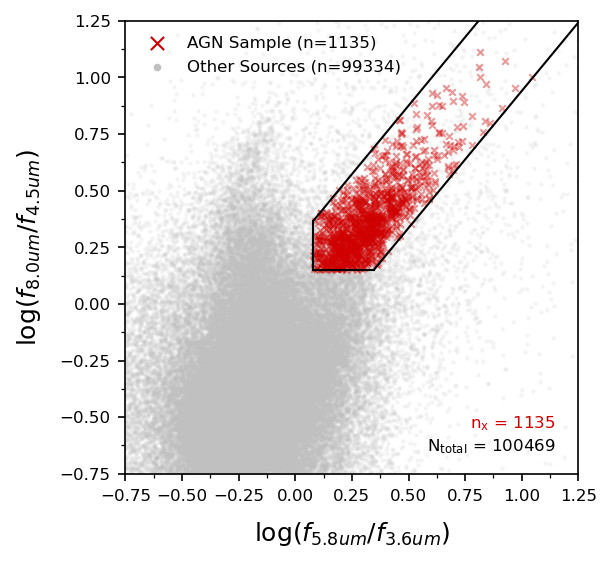

In [25]:
PlotIRAC_two(
    x_noAGN3, y_noAGN3,
    x_yesAGN3,y_yesAGN3,
    save='v2_Data_mirAGN_andAllCOSMOS',
)

In [26]:
def PlotIRAC_one(
    x_agn,y_agn,
    save=''
):
    # set default style preferences 
    adp.SetStyle() 

    # get plot axis
    ax = plt.gca()

    # plot color vs color 
    agn = ax.scatter(x_agn,  y_agn,  c=adp.c_ir, marker='.', s=1,  alpha=1.0, label='AGN Sample (n='+str(len(x_agn))+')')

    # plot wedge shape 
    adp.PlotDonleyWedge()

    # format
    plt.axis([-0.25,1.25,-0.25,1.25]) 
    adp.AddText_n(len(x_agn))

    # axis 
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([-0.25,0.0,0.25,0.50,0.75,1.0,1.25])
    ax.set_yticks([-0.25,0.0,0.25,0.50,0.75,1.0,1.25])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # save if given a name 
    if(save):
        adp.Save(adp.path_fig+'\\'+save+'.png')
        
    # show plot 
    plt.show()

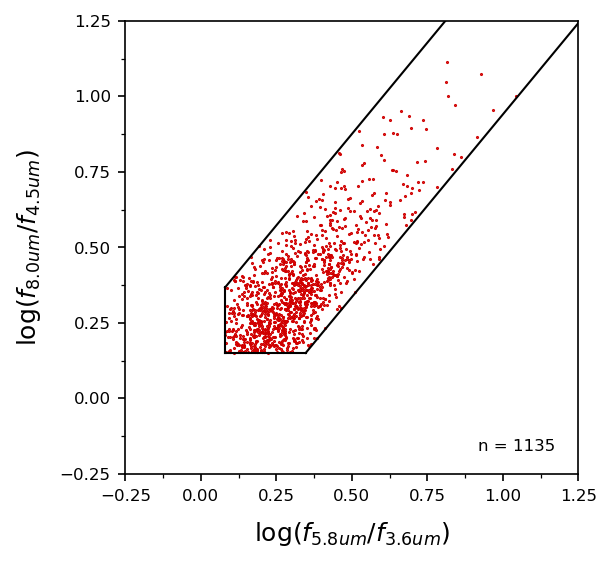

In [27]:
PlotIRAC_one(
    x_yesAGN3,y_yesAGN3,
    save='v2_Data_mirAGN',
)

# X-ray Selection

In [74]:
# correct luminosity for absorbtion
# Lint_data = adp.IntrinsicLuminosity(L0510_data, k0510_data)
Lint_data = L0510_data # new catalog already corrected for absorbtion

In [78]:
# get mask of sources that have intrinsic Xray lum > 10^43 erg/s
xrayAGNmask = adp.AGN_Xray(Lint_data)

In [79]:
# apply data cuts 
data16_id_agn      = data16_id[xrayAGNmask]                      # 0. agn (no restrictions)
data16_id_agn_1    = data16_id[xrayAGNmask & data16_id_cut1   ]  # 1. Must have id
data16_id_agn_12   = data16_id[xrayAGNmask & data16_id_cut12  ]  # 2. must have redshift
data16_id_agn_123  = data16_id[xrayAGNmask & data16_id_cut123 ]  # 3. must have all four IRAC detections
data16_id_agn_1234 = data16_id[xrayAGNmask & data16_id_cut1234]  # 4. must have 24um detection with fractional error < 50%

In [80]:
# print number of sources 
print('Number of sources:\t\t\t',                  len(data16_id))
print('Number of X-ray AGN:\t\t\t',                len(data16_id_agn))
print('Number of X-ray AGN (w/id):\t\t',           len(data16_id_agn_1))
print('Number of X-ray AGN (w/id,z):\t\t',         len(data16_id_agn_12))     # 2232 = previous work
print('Number of X-ray AGN (w/id,z,irac):\t',      len(data16_id_agn_123))    # 2025 = previous work
print('Number of X-ray AGN (w/id,z,irac,24um):\t', len(data16_id_agn_1234))   # 1517 = previous work

Number of sources:			 865086
Number of X-ray AGN:			 2721
Number of X-ray AGN (w/id):		 2721
Number of X-ray AGN (w/id,z):		 2721
Number of X-ray AGN (w/id,z,irac):	 2492
Number of X-ray AGN (w/id,z,irac,24um):	 1870


# X-ray Data Scatterplots

In [81]:
# GET SOURCES NOT AGN

# match ids to get z
key_id, key_z = match.match(data16_id[data16_id_cut12 & ~(xrayAGNmask & data16_id_cut123)], zTable_id)
z  = zTable_z[key_z]

# get intrinsic Xray luminosity with redshifts 
Lx = Lint_data[data16_id_cut12 & ~(xrayAGNmask & data16_id_cut123)][key_id]
print(len(Lx))

# get good data points
mask_nonzeroLx = Lx > 0
Lx_nonzero = Lx[mask_nonzeroLx]
z_Lxnonzero = z[mask_nonzeroLx]
print(len(z_Lxnonzero))


473809
836


In [82]:
# NOW GET X-RAY AGN w/ data cuts
key_id, key_z = match.match(data16_id[xrayAGNmask & data16_id_cut123], zTable_id)
z_agn_123  = zTable_z[key_z]
Lx_agn_123 = Lint_data[xrayAGNmask & data16_id_cut123][key_id]
print(len(z_agn_123))

2492


In [106]:
def PlotLxVSz_two(
        Lx, z,
        Lx_agn, z_agn,
        save=''
    ) : 

    # set plot defaults
    adp.SetStyle()
    
    # get plot axis
    ax = plt.gca()

    # plot all luminosity points
    othr = ax.scatter(z,      Lx,     marker='.', s=7,  c='silver',   label='Other Sources (n='+str(len(z))+')',   alpha=0.5)              
    agn  = ax.scatter(z_agn,  Lx_agn, marker='x', s=10, c=adp.c_xray, label='AGN Sample (n='+str(len(z_agn))+')' , alpha=0.5)
    # # adp.PlotContours_ax(ax, np.concatenate([z,z_agn]), np.concatenate([Lx,Lx_agn]))

    # plot horizontal dashed line at 10^43 erg/s
    plt.axhline(y=43, color='k', linestyle='dashed')

    # # plt.title('Redshift VS. X-ray luminosity from all Chandra 2016 sources')
    plt.xlabel('z')
    plt.ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    adp.AddText_n(len(z)+len(z_agn), pre='$\mathrm{N_{total}}$ = ')
    adp.AddText_n2_ax(ax, len(z_agn), pre='$\mathrm{n_x}$ = ', color=adp.c_xray)

    # axis
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_yticks([40,41,42,43,44,45,46])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # save if given a name 
    if(save):
        # save copy without legend
        adp.Save(adp.path_fig+'\\'+save+'.png')
        # save copy with legend
        leg = plt.legend(handles=[agn,othr],loc='upper right', markerscale=2, fontsize=8, frameon=False)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)        
        adp.Save(adp.path_fig+'\\'+save+'_legend.png')
    else: 
        # show legend 
        leg = plt.legend(handles=[agn,othr],loc='upper right', markerscale=2, fontsize=8)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    # show plot 
    plt.show()


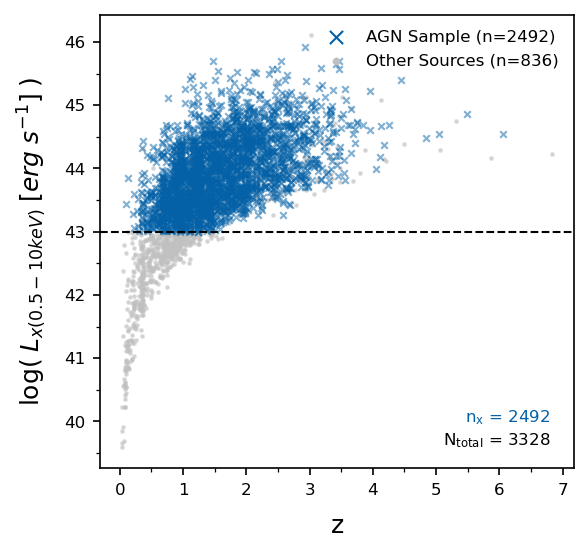

In [107]:
PlotLxVSz_two(
    Lx_nonzero,z_Lxnonzero,
    Lx_agn_123, z_agn_123,
    save='v2_Data_XrayAGN_andAllCCOSMOS'
)

In [108]:
def PlotLxVSz_one(
        Lx, z,
        save=''
    ) : 
    adp.SetStyle()

    # plot all luminosity points
    plt.scatter(z, Lx, marker='.', c=adp.c_xray, s=2)

    # plt.title('Redshift VS. X-ray luminosity from all Chandra 2016 sources')
    plt.xlabel('z')
    plt.ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    adp.AddText_n(len(z))

    # axis
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_yticks([43,44,45,46])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    # save if given a name 
    if(save):
        adp.Save(adp.path_fig+'\\'+save+'.png')
        
    # show plot 
    plt.show()

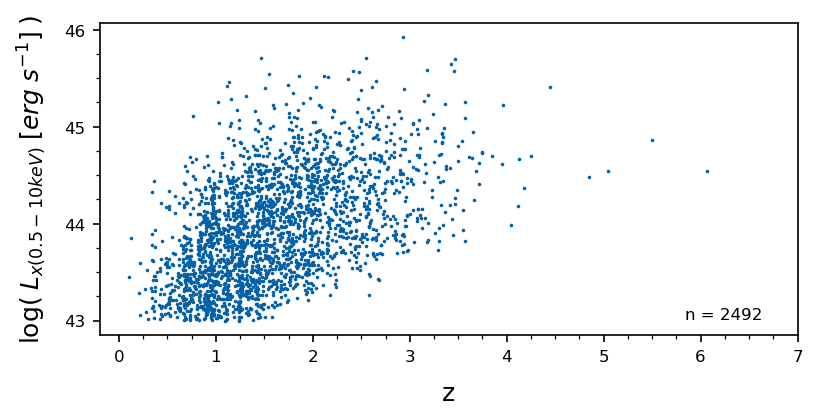

In [109]:
PlotLxVSz_one(
    Lx_agn_123, z_agn_123,
    save='v2_Data_XrayAGN'
)

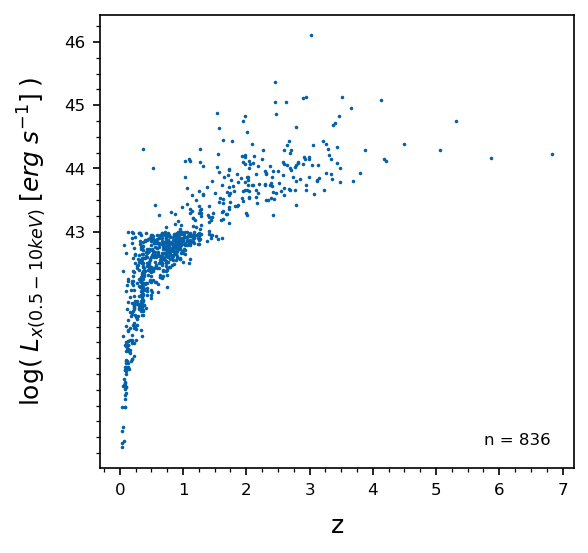

In [110]:
# visualize AGNs that do not have IRAC colors and are logLx<43
PlotLxVSz_one(
    Lx_nonzero, z_Lxnonzero,
)

# Export IDs of AGN

In [111]:
# write IDs of AGN by selection method
with open(adp.path_csv+'\\v2_AGNid_Xray_MIR.csv', mode='w', newline='') as csv_file:
    # initialize csv
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write to file 
    writer.writerow([
        'Row 1 = MIR selected AGN (Donley et al, 2012) with id, redshift, and IRAC (n='+str(len(data20_id_agn_123))+'). '+ 
        'Row 2 = X-ray selected AGN (Lx > 10^43 erg/s) with id, redshift, and IRAC (n='+str(len(data16_id_agn_123))+'). '
    ])
    writer.writerow(data20_id_agn_123)
    writer.writerow(data16_id_agn_123)
    # confirm 
    print('List saved: v2_AGNid_Xray_MIR.csv')


List saved: v2_AGNid_Xray_MIR.csv
